In [2]:
# Suppress future and deprecation warnings
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Standard Packages
import pandas as pd
import numpy as np
import datetime

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats 

# Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SKLearn Modules
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# Location visualization
import folium
from folium.plugins import MarkerCluster
import streamlit as st
from streamlit_folium import folium_static

In [3]:
# Load previously created dataframes
df_king = pd.read_pickle('data/df_king.pkl')
df1 = pd.read_pickle('data/df1.pkl')
df2 = pd.read_pickle('data/df2.pkl')
df3 = pd.read_pickle('data/df3.pkl')
df4 = pd.read_pickle('data/df4.pkl')
df5 = pd.read_pickle('data/df5.pkl')
df15 = pd.read_pickle('data/df15.pkl')

In [4]:
df15.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'zipcode', 'gradeno',
       'class'],
      dtype='object')

In [9]:
feature_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors',  'yr_built', 'yr_renovated', 'class']

X = df15[feature_cols].copy()
X = sm.add_constant(X)
y = df15['price']

# VIF for each independent
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

print(vif.sort_values(ascending=False))

# Select the 2 features with the lowest VIF
selected_cols = vif.sort_values().index[0:2]

model = sm.OLS(y, X).fit()
print(model.summary())


const           4332.677432
bathrooms          3.470331
sqft_living        3.083322
bedrooms           1.770490
yr_built           1.475153
floors             1.239308
class              1.179326
yr_renovated       1.070929
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     195.7
Date:                Thu, 16 Feb 2023   Prob (F-statistic):          1.03e-192
Time:                        14:52:08   Log-Likelihood:                -18154.
No. Observations:                1193   AIC:                         3.632e+04
Df Residuals:                    1185   BIC:                         3.636e+04
Df Model:                           7                                         
Covariance Type:            nonrobust             

In [25]:
# def reject_outliers(df):
#     """Perform 1.5*IQR outlier rejection for all columns in a dataset"""
#     for col in df.columns:
#         if np.issubdtype(df[col].dtype, np.number):
#             q1 = df[col].quantile(0.25)
#             q3 = df[col].quantile(0.75)
#             iqr = q3 - q1
#             lower_bound = q1 - 1.5 * iqr
#             upper_bound = q3 + 1.5 * iqr
#             df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
#     return df

def reject_outliers_col(df, col):
    """Perform 1.5*IQR outlier rejection on a single column of a DataFrame"""
    if np.issubdtype(df[col].dtype, np.number):
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [26]:
df_king.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'zipcode', 'gradeno'],
      dtype='object')

In [29]:
df_king_iqr = df_king

reject_outliers_col(df_king_iqr, 'price')
reject_outliers_col(df_king_iqr, 'sqft_living')
reject_outliers_col(df_king_iqr, 'sqft_lot')
reject_outliers_col(df_king_iqr, 'sqft_above')
reject_outliers_col(df_king_iqr, 'sqft_basement')
df_king_iqr.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode,gradeno
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,7
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133,7
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178,7
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118,9
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027,7


In [30]:
def get_class(row):
    if row['condition'] <= 2:
        return 0
    elif row['condition'] == 3 and row['gradeno'] <= 7:
        return 0
    elif row['condition'] == 5:
        return 2
    elif row['condition'] == 4 and row['gradeno'] >= 9:
        return 2
    else:
        return 1
df_king_iqr['class'] = df_king_iqr.apply(get_class, axis=1)

In [53]:
def regressionsm(df,X,y):
    model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=X_train.columns,
                              index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled,
                             columns=X_test.columns,
                             index=X_test.index)
    
    model_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
    return model_OLS.summary()

In [54]:
X = df_king_iqr[['sqft_living']]
y= df_king_iqr[['price']]
regressionsm(df_king_iqr, X, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                 1.426e+04
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:06:01   Log-Likelihood:            -3.2593e+05
No. Observations:               21909   AIC:                         6.519e+05
Df Residuals:                   21907   BIC:                         6.519e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.116e+06   4722.479    236.340      0.000    1.11e+06    1.13e+06
sqft_living   5.64e+05   4722.479    119.432      0.000    5.55e+05    5.73e+05
==============================================================================
Omnibus:                    27762.961   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12702298.298
Skew:                           6.603   Prob(JB):                         0.00
Kurtosis:                     120.219   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# scaler = StandardScaler()

# X_unscaled = df_king_iqr[['sqft_living']]
# scaler.fit(X_unscaled)
# X_unscaled_scaled = scaler.transform(X_unscaled)
# X_unscaled_scaled = pd.DataFrame(X_unscaled_scaled, columns=X_unscaled.columns, index=X_unscaled.index)
# model = LinearRegression()
# model.fit(X_unscaled_scaled, y)
# price_increase_per_std_sqft_living = model.coef_[0][0] * np.std(df_king_iqr['sqft_living'])
# print(price_increase_per_std_sqft_living)

539470335.1246512


In [55]:
y = np.log(df_king_iqr['price'])
X = df_king_iqr['sqft_living']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                 1.866e+04
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:06:05   Log-Likelihood:                -18627.
No. Observations:               29212   AIC:                         3.726e+04
Df Residuals:                   29210   BIC:                         3.727e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9399      0.006   2013.880      0.000      12.927      12.953
sqft_living     0.0004   2.74e-06    136.585      0.000       0.000       0.000
==============================================================================
Omnibus:                     5799.628   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45114.585
Skew:                          -0.745   Prob(JB):                         0.00
Kurtosis:                       8.903   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

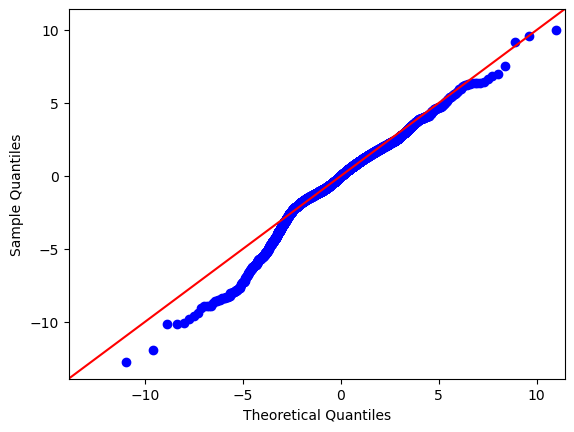

In [56]:
y_pred = model.predict(X)
residuals = y - y_pred
fig = sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.show()

In [57]:
np.exp(model.params['sqft_living']) * np.mean(df_king_iqr['price']) - np.mean(df_king_iqr['price'])

416.619377161609

In [58]:
X = df15[['sqft_living']]
y= df15[['price']]
regressionsm(df15, X, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     936.7
Date:                Fri, 17 Feb 2023   Prob (F-statistic):          3.30e-141
Time:                        10:06:18   Log-Likelihood:                -13640.
No. Observations:                 894   AIC:                         2.728e+04
Df Residuals:                     892   BIC:                         2.729e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.081e+06   3.43e+04     60.740      0.000    2.01e+06    2.15e+06
sqft_living  1.049e+06   3.43e+04     30.606      0.000    9.81e+05    1.12e+06
==============================================================================
Omnibus:                      368.594   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2254.993
Skew:                           1.772   Prob(JB):                         0.00
Kurtosis:                       9.927   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
y = np.log(df15['price'])
X = df15['sqft_living']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     1146.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):          1.56e-176
Time:                        10:06:22   Log-Likelihood:                -740.13
No. Observations:                1193   AIC:                             1484.
Df Residuals:                    1191   BIC:                             1494.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.4181      0.030    441.009      0.000      13.358      13.478
sqft_living     0.0004   1.03e-05     33.852      0.000       0.000       0.000
==============================================================================
Omnibus:                      182.977   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1415.483
Skew:                          -0.461   Prob(JB):                    4.28e-308
Kurtosis:                       8.256   Cond. No.                     6.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

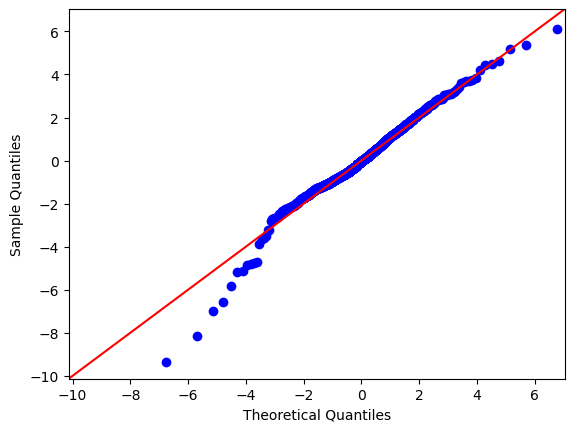

In [60]:
y_pred = model.predict(X)
residuals = y - y_pred
fig = sm.qqplot(residuals, stats.t, fit=True, line='45')
plt.show()

In [61]:
np.exp(model.params['sqft_living']) * np.mean(df_king_iqr['price']) - np.mean(df_king_iqr['price'])

389.5787148103118

In [62]:
print(df_king.price.mean())
print(df_king.sqft_living.mean())
print(df_king.bedrooms.mean())
print(df_king.bathrooms.mean())
print(df_king.condition.mean())
print(df_king.gradeno.mean())

1112556.1280638094
2130.620053402711
3.43523209639874
2.3318670409420785
3.486375462138847
7.636313843625907


In [63]:
print(df15.price.mean())
print(df15.sqft_living.mean())
print(df15.bedrooms.mean())
print(df15.bathrooms.mean())
print(df15.condition.mean())
print(df15.gradeno.mean())

2080924.8005029338
2658.082145850796
3.7158424140821458
2.676865046102263
3.4668901927912823
8.353730092204527


<AxesSubplot:xlabel='sqft_living', ylabel='Count'>

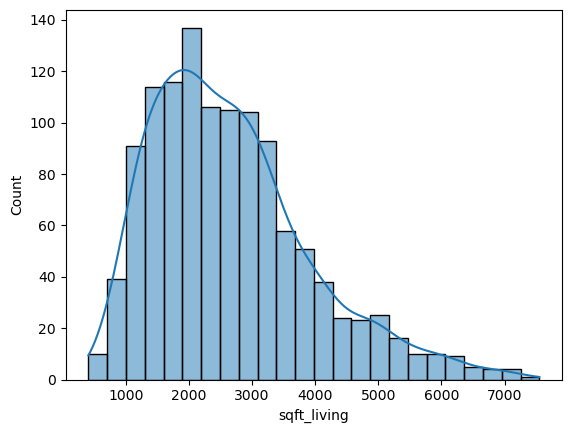

In [66]:
sns.histplot(df15['sqft_living'], kde = True)